UMAP : Uniform Manifold Approximation

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [7]:
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')
print(df.columns.tolist())

['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


Separation of the features X and the target Y

In [8]:
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])
# On drop évidemment le prix discret et le label de ville inutile ici

print(f"\nFeatures (X) : {X.shape[1]} colonnes")
print(f"Target (y) : {len(y)} valeurs")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())


Features (X) : 27 colonnes
Target (y) : 73111 valeurs

Distribution des classes :
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64


Train test split 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=123
)  # on stratify pour garder la même répartition des classes dans train et test

Sous-échantillonnage pour UMAP : 10000 samples


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


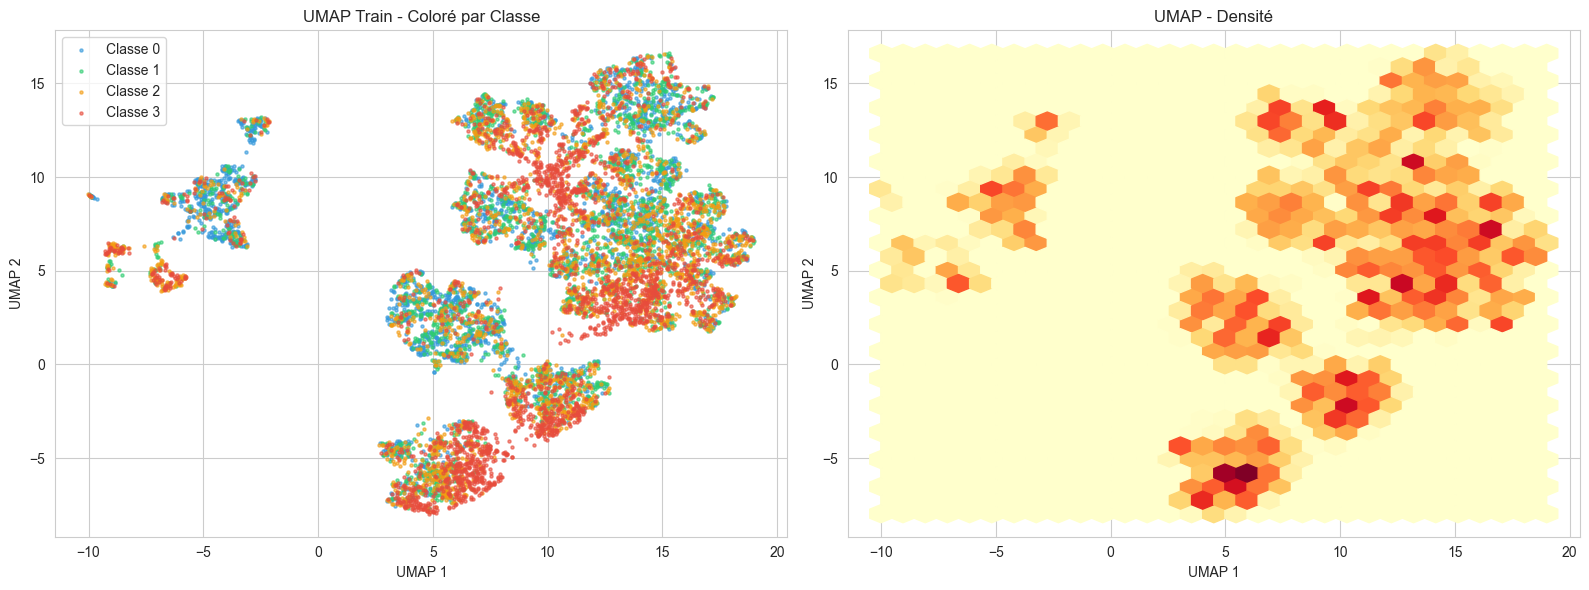

In [10]:
# UMAP sur train (sous-échantillon si trop volumineux)
scaler_pca = StandardScaler()
X_train_std = scaler_pca.fit_transform(X_train)

sample_size = min(10000, len(X_train))
if len(X_train) > sample_size:
    print(f"Sous-échantillonnage pour UMAP : {sample_size} samples")
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train_std[indices]
    y_train_sample = y_train.iloc[indices]
else:
    X_train_sample = X_train_std
    y_train_sample = y_train

reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42, verbose=False)
embedding_train = reducer.fit_transform(X_train_sample)

# Visualisations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Coloré par classe
colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
for classe in range(4):
    mask = y_train_sample == classe
    axes[0].scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
                   c=colors_class[classe], label=f'Classe {classe}', s=5, alpha=0.6)
axes[0].set_title("UMAP Train - Coloré par Classe")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend()

# Densité
axes[1].hexbin(embedding_train[:, 0], embedding_train[:, 1], gridsize=30, cmap='YlOrRd')
axes[1].set_title("UMAP - Densité")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

Relevance of UMAP

Useful for exploration / diagnosis but not really as a feature-engineering step for the final predictor :

- EDA / sanity checks: 
Non-linear dimensionality reduction method --> used for visualization and exploring structure (clusters, outliers...): to see whether the quartile classes overlap heavily (hard classification problem) or separate somewhat (easier).

- Detecting weird outliers: 
Isolated islands --> groups like “luxury + big apartments”, “tiny studios” : useful for cleaning and feature design—even 
- UMAP is interesting for us here because the dataset is very big


However, not the best choice in our setting for boosting prediction accuracy on tabular data with ~30 features

UMAP isn’t necessary because not a high-dimensional regime where dimensionality reduction is crucial: 

UMAP’s objective is to preserve neighborhood structure in a low-dimensional embedding (for visualization), but that embedding can discard information useful for predicting price bins.

- Tree-based models are stronger at learning non-linear interactions directly from the original features --> compressing features often brings little benefit as UMAP is not primarily designed as a supervised predictor.

When UMAP can help prediction (worth trying) :

UMAP more relevant as a predictive feature step if :
- Very high-dimensional inputs (common in Airbnb: thousands of one-hot amenities, text embeddings from descriptions, image embeddings, etc.) --> UMAP is explicitly positioned as scalable and usable beyond just 2D plots.
- You plan to use distance/neighborhood-based models downstream (kNN-like logic), because UMAP is built around neighborhood graphs.